# PA3 ECE421 Answers
### The experiment results are below the code, scroll past the code to see them.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Function for loading notMNIST Dataset
def loadData(datafile = "notMNIST.npz"):
    with np.load(datafile) as data:
        Data, Target = data["images"].astype(np.float32), data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Custom Dataset class.
class notMNIST(Dataset):
    def __init__(self, annotations, images, transform=None, target_transform=None):
        self.img_labels = annotations
        self.imgs = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

class CNN(nn.Module):
    def __init__(self, drop_out_p=0.0):
        super(CNN, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4)
        self.batchnorm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4)
        self.batchnorm2 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(p=drop_out_p)
        self.fullconn1 = nn.Linear(1024, 784)
        self.fullconn2 = nn.Linear(784, 10)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.pool(x)

        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.pool(x)

        x = torch.flatten(x, start_dim=1)  # will be (BATCH_SIZE, 1024)
        x = self.dropout(x)

        x = F.relu(self.fullconn1(x))
        x = self.fullconn2(x)

        return x


class FNN(nn.Module):
    def __init__(self, drop_out_p=0.0):
        super(FNN, self).__init__()
        self.fullconn1 = nn.Linear(784, 10)
        self.fullconn2 = nn.Linear(10, 10)
        self.dropout = nn.Dropout(p=drop_out_p)
        self.fullconn3 = nn.Linear(10, 10)


    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fullconn1(x))
        x = F.relu(self.fullconn2(x))
        x = self.dropout(x)
        x = self.fullconn3(x)
        return x


# Commented out IPython magic to ensure Python compatibility.
# Compute accuracy
def get_accuracy(model, dataloader):

    model.eval()
    device = next(model.parameters()).device
    accuracy = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            results = model(images)
            _, prediction = torch.max(results, 1)
            correct_predictions += (prediction == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions

    return accuracy

def train(model, device, learning_rate, weight_decay, train_loader, val_loader, test_loader, num_epochs=50, verbose=False):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  acc_hist = {'train':[], 'val':[], 'test': []}

  for epoch in range(num_epochs):
    model = model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        results = model(images)
        loss = criterion(results, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    acc_hist['train'].append(get_accuracy(model, train_loader))
    acc_hist['val'].append(get_accuracy(model, val_loader))
    acc_hist['test'].append(get_accuracy(model, test_loader))

    if verbose:
      print('Epoch: %d | Train Accuracy: %.2f | Validation Accuracy: %.2f | Test Accuracy: %.2f' \
           %(epoch, acc_hist['train'][-1], acc_hist['val'][-1], acc_hist['test'][-1]))

  return model, acc_hist

def experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.5, weight_decay=0.01, num_epochs=50, verbose=False):
  # Use GPU if it is available.
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  # Inpute Batch size:
  BATCH_SIZE = 32

  # Convert images to tensor
  transform = transforms.Compose(
      [transforms.ToTensor()])

  # Get train, validation and test data loader.
  trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

  train_data = notMNIST(trainTarget, trainData, transform=transform)
  val_data = notMNIST(validTarget, validData, transform=transform)
  test_data = notMNIST(testTarget, testData, transform=transform)


  train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

  # Specify which model to use
  if model_type == 'CNN':
    model = CNN(dropout_rate)
  elif model_type == 'FNN':
    model = FNN(dropout_rate)


  # Loading model into device
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  model, acc_hist = train(model, device, learning_rate, weight_decay, train_loader, val_loader, test_loader, num_epochs=num_epochs, verbose=verbose)

  # Release the model from the GPU (else the memory wont hold up)
  model.cpu()

  return model, acc_hist


# Experiment 1: Comparing Architectures

Training CNN...

Training FNN...



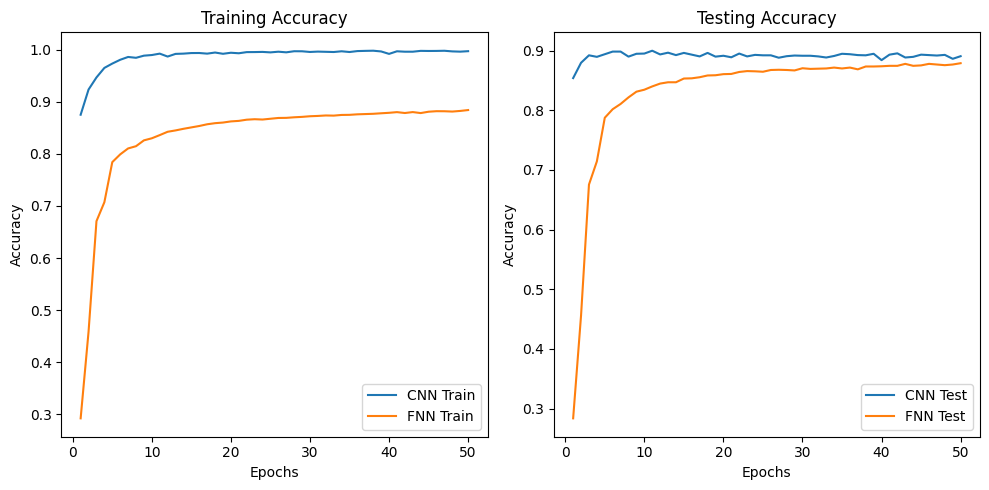

In [ ]:

def compare_arch():
    print("Training CNN...\n")
    _, acc_hist_cnn = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=0.0, num_epochs=50, verbose=False)
    print("Training FNN...\n")
    _, acc_hist_fnn = experiment(model_type='FNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=0.0, num_epochs=50, verbose=False)

    epochs = range(1, 51)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc_hist_cnn['train'], label='CNN Train')
    plt.plot(epochs, acc_hist_fnn['train'], label='FNN Train')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_hist_cnn['test'], label='CNN Test')
    plt.plot(epochs, acc_hist_fnn['test'], label='FNN Test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_arch()


### In this experiment, we see that the CNN consistently achieves better accuracy than the FNN, confirming that CNNs are the better architecture for image classification. CNN catures spatial information by using kernels which RNN lacks, so it performs better when it comes to tasks that contains spatial information (relative location).

# Experiment 2: Comparing dropouts



Training with dropout rate: 0.5...

Training with dropout rate: 0.8...

Training with dropout rate: 0.95...



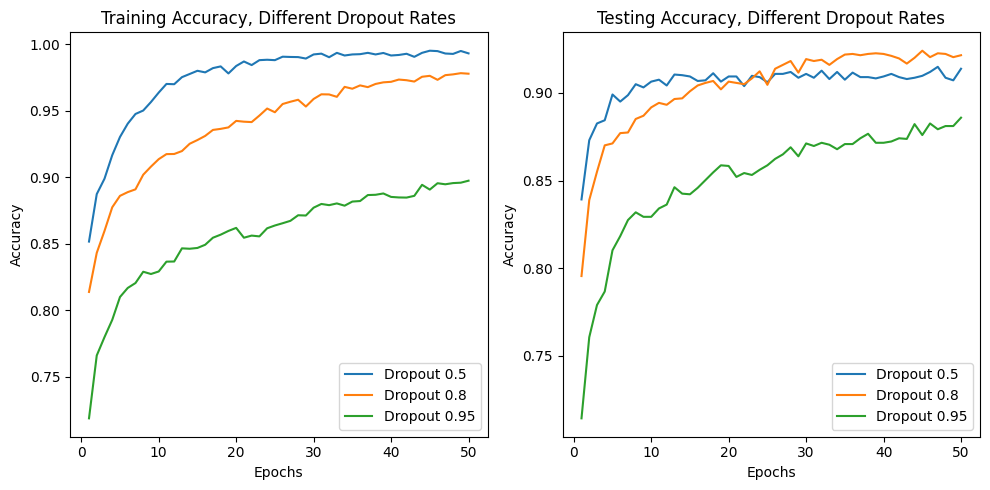

In [ ]:

def compare_dropout():
    dropout_rates = [0.5, 0.8, 0.95]
    acc_histories = {}

    for rate in dropout_rates:
        print(f"Training with dropout rate: {rate}...\n")
        _, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=rate, weight_decay=0.0, num_epochs=50, verbose=False)
        acc_histories[rate] = acc_hist

    epochs = range(1, 51)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    for rate in dropout_rates:
        plt.plot(epochs, acc_histories[rate]['train'], label=f'Dropout {rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy, Different Dropout Rates')
    plt.legend()

    plt.subplot(1, 2, 2)
    for rate in dropout_rates:
        plt.plot(epochs, acc_histories[rate]['test'], label=f'Dropout {rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy, Different Dropout Rates')
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_dropout()

We see that 0.95 dropout performs much more poorly than the other two cases, likely because it is too high, and the model is thus underfitting the data.

Dropout of 0.5 performs better than dropout of 0.8 on the training data, however, the 0.8 case is performing better on the testing data, indicating the 0.5 case may be overfitting a bit to the training data, while the 0.8 case is mitigating that issue.

Also, the 0.8 case performs better than the previous no dropout case (from experiment 1) on the testing data, likely because in experiment 1 we were overfitting somewhat to the training data.

In sum it seems that higher dropout prevents overfitting to training data, but too high can lead to underfitting.

# Experiment 3: Weight Decay Comparison


Training with weight decay: 0.1
Training with weight decay: 1.0
Training with weight decay: 10.0


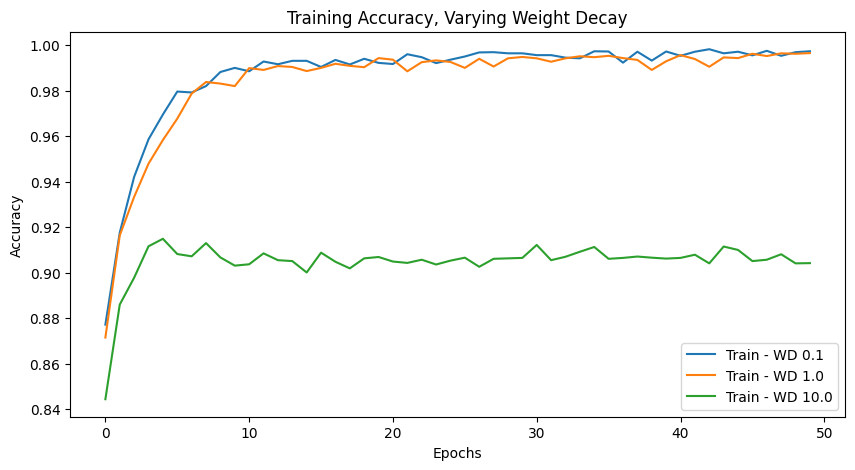

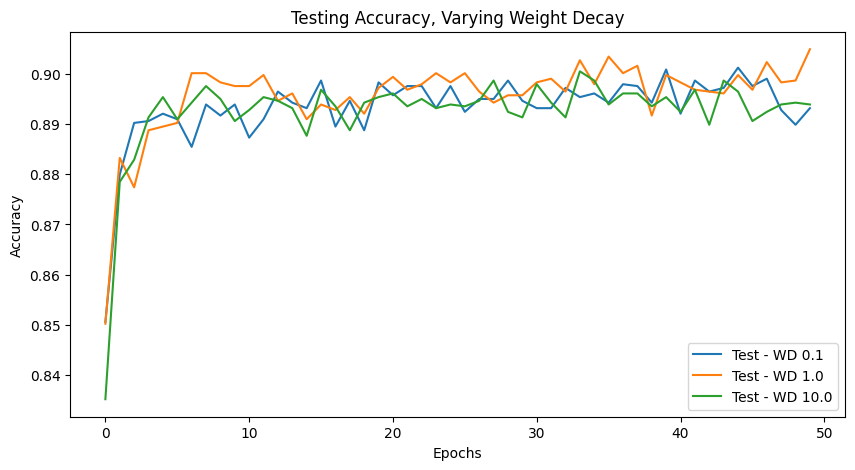

In [ ]:
def compare_l2():
    weight_decays = [0.1, 1.0, 10.0]
    acc_histories = {}

    for wd in weight_decays:
        print(f"Training with weight decay: {wd}")
        model, acc_hist = experiment(model_type='CNN', learning_rate=0.0001, dropout_rate=0.0, weight_decay=wd, num_epochs=50, verbose=False)
        acc_histories[wd] = acc_hist

    plt.figure(figsize=(10, 5))
    for wd in weight_decays:
        plt.plot(acc_histories[wd]['train'], label=f'Train - WD {wd}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy, Varying Weight Decay')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for wd in weight_decays:
        plt.plot(acc_histories[wd]['test'], label=f'Test - WD {wd}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy, Varying Weight Decay')
    plt.legend()
    plt.show()

compare_l2()

On the training set, weight decay 0.1 and 1.0 perform similarly, while 10.0 performs significantly worse, indicating the high weight decay is causing the model to underfit on the training data.

Interestingly enough, on the test set all cases perform similarly. This indicates that the high weight decay of 10.0, while causes underfitting on the training data and reduces learning capacity in general, still allows the model to learn the correct features that will generalize will to other, unseen data.

In general we see that weight decay can help prevent overfitting to the training data, while still allowing the model to learn more generalizable features.